# **Kino Deep Neural Network**

We will have 3 different sections:
- Section 1 - Write function to fetch the data
- Section 2 - Fetch data and store it in csv file
- Section 3 - Create the DNN and train on data
- Section 4 - Predict next Draws

# Section 1 - Write function to fetch the data

In [3]:
import requests

In [4]:
current_draw = 'https://api.opap.gr/draws/v3.0/1100/last-result-and-active'

In [5]:
  response = requests.get(current_draw)
  data = response.json()

  # Get Draw ID
  draw_id = data['last']['drawTime']

In [6]:
def get_active_draw():

  # Make API call
  response = requests.get(current_draw)
  data = response.json()

  # Get Draw ID
  draw_id = data['last']['drawId']

  # Get winning numbers and sort them
  winning_numbers = data['last']['winningNumbers']['list']
  winning_numbers.sort()

  # Get datetime
  timestamp = data['last']['drawTime']
  date = datetime.datetime.fromtimestamp(timestamp / 1e3)
  month = date.month
  day = date.day
  hour = date.hour
  minute = date.minute

  return draw_id, winning_numbers, month, day, hour, minute

In [7]:
def get_draw(draw_id):
  
  # Make API call
  response = requests.get(f'https://api.opap.gr/draws/v3.0/1100/{draw_id}')
  data = response.json()

  # Get winning numbers and sort them
  winning_numbers = data['winningNumbers']['list']
  winning_numbers.sort()

  # Get datetime
  timestamp = data['drawTime']
  date = datetime.datetime.fromtimestamp(timestamp / 1e3)
  month = date.month
  day = date.day
  hour = date.hour
  minute = date.minute

  return winning_numbers, month, day, hour, minute

# Section2 - Fetch data and store it in csv file

In [8]:
import time
import pandas as pd
import datetime
import matplotlib.pyplot as plt

From some tests i performed i found that the respective times required for N draws are:
- **100** draws in **18.54** seconds
- **200** draws in **35.47** seconds
- **500** draws in **89.80** seconds
- **1000** draws in **186.87** seconds
- **1500** draws in **299.32** seconds

So in order not to lose some draws see what best fits for you regarding your internet speed! Five minutes is the limit (**300s**) !

Or you can fetch many past data and train only on them.

In [9]:
draws_df = pd.read_csv('./kino.csv')

In [11]:
# How many draws from the past to get 
num_of_prev_draws_to_get =  1000#@param {type:"integer"}

In [13]:
# Start count time
start = time.time()

num_calls = []
time_taken = []

# Get previous draw ID
previous_draw_id , _ , _ , _ , _ , _ = get_active_draw()

winning_numbers, month, day, hour, minute = get_draw(previous_draw_id-num_of_prev_draws_to_get)

# Initialize dataframe
draws_df = pd.DataFrame([{'Winning Numbers':winning_numbers,'Month':month,'Day':day,'Hour':hour,'Minute':minute}])
i = 1;
for draw_id in range(previous_draw_id - num_of_prev_draws_to_get + 1,previous_draw_id):
  i+=1
  winning_numbers, month, day, hour, minute = get_draw(draw_id)
  row_to_append = pd.Series([winning_numbers, month, day, hour, minute], index = draws_df.columns)
  draws_df = draws_df.append(row_to_append, ignore_index=True)
  if i % 100 == 0:
    num_calls.append(i)
    time_passed = round(time.time() - start,2)
    time_taken.append(time_passed)
    print(f'Fetched {i} draws in {time_passed}s')

# Save dataframe
draws_df.to_csv('kino.csv',index=False)

 ### Plot time taken based on num of API calls

In [ ]:
position = time_taken.index(300-min([300-passed_time for passed_time in time_taken if 300-passed_time>0]))

font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        };

title_font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 24,
        };
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(time_taken,num_calls);
plt.plot(time_taken[position],num_calls[position],'bo',markersize=10)
plt.text(time_taken[position],num_calls[position]-100,f'Max calls {num_calls[position]}')
plt.title('Time taken for API calls', fontdict=title_font);
plt.xlabel('Time Taken (s)', fontdict=font);
plt.ylabel('Count of Api Calls', fontdict=font);
plt.axis([min(time_taken),max(time_taken),100,num_of_prev_draws_to_get,])
plt.grid(True)

# Section 3 - Create the DNN and train on data

In [108]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.layers import Dense, Input, LSTM, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras.utils.vis_utils import plot_model
from keras.losses import MeanSquaredError, SparseCategoricalCrossentropy
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [96]:
# Dataframe Rows
rows = len(draws_df.index)

epochs =  90#@param {type:"slider", min:20, max:300, step:10}
previous_draws =  20#@param {type:"slider", min:2, max:40, step:1}
lstm_units =  524#@param {type:"integer"}

test_data =  500#@param {type:"slider", min:50, max:1000, step:50}

In [117]:
input = Input((previous_draws*20), name="digits")
x = Dense(516, activation='relu')(input)
x = Dense(254, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(20,name="predictions")(x)

model = Model(input, output)
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          [(None, 400)]             0         
_________________________________________________________________
dense_43 (Dense)             (None, 516)               206916    
_________________________________________________________________
dense_44 (Dense)             (None, 254)               131318    
_________________________________________________________________
dense_45 (Dense)             (None, 128)               32640     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_47 (Dense)             (None, 32)                2080      
_________________________________________________________________
predictions (Dense)          (None, 20)                660

In [120]:
optimizer = Adam()
loss = MeanSquaredError()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)

model.compile(optimizer, loss)

In [81]:
# This is for data read from csv so i have to take more actions to pass it as list of int
X = []
Y = []

for i in range(previous_draws,rows):
    
    # Get N previous draws
    inputs = []
    for j in range(previous_draws,0,-1):
        winning_numbers = draws_df.loc[j]['Winning Numbers']
        winning_numbers = winning_numbers[1:-1]
        for k in winning_numbers.split(', '):
            inputs.append(int(k))
            
    X.append(inputs)

    target = []
    winning_numbers = draws_df.loc[i]['Winning Numbers']
    winning_numbers = winning_numbers[1:-1]
    for i in winning_numbers.split(', '):
        target.append(int(i))
    
    Y.append(target)

In [16]:
# This is for the data fetched from the API
X = []
Y = []

for i in range(previous_draws,rows):

    # Get N previous draws
    inputs = []
    for j in range(previous_draws,0,-1):
      inputs += draws_df.loc[i-j]['Winning Numbers']
    X.append(inputs)

    # Get target draw
    Y.append(draws_df.loc[i]['Winning Numbers'])

In [82]:
x_train = X[:-test_data]
y_train = Y[:-test_data]
x_test = X[-test_data:]
y_test = Y[-test_data:]

In [121]:
history = model.fit(x_train, y_train, batch, epochs=epochs, validation_data=(x_test, y_test), callbacks=[reduce_lr, early_stopping])

Epoch 1/90
297/297 [==============================] - 3s 7ms/step - loss: 570.4669 - val_loss: 42.8320
Epoch 2/90
297/297 [==============================] - 1s 3ms/step - loss: 41.5243 - val_loss: 42.8319
Epoch 3/90
297/297 [==============================] - 1s 3ms/step - loss: 39.2209 - val_loss: 50.0001
Epoch 4/90
297/297 [==============================] - 1s 3ms/step - loss: 42.9568 - val_loss: 44.9256
Epoch 5/90
297/297 [==============================] - 1s 3ms/step - loss: 41.0613 - val_loss: 48.7894
Epoch 6/90
297/297 [==============================] - 1s 3ms/step - loss: 42.1390 - val_loss: 47.1232
Epoch 7/90
297/297 [==============================] - 1s 3ms/step - loss: 40.4590 - val_loss: 43.8477
Epoch 8/90
297/297 [==============================] - 1s 3ms/step - loss: 40.4739 - val_loss: 42.6389
Epoch 9/90
297/297 [==============================] - 1s 3ms/step - loss: 40.2362 - val_loss: 46.7497
Epoch 10/90
297/297 [==============================] - 1s 3ms/step - loss: 39.320

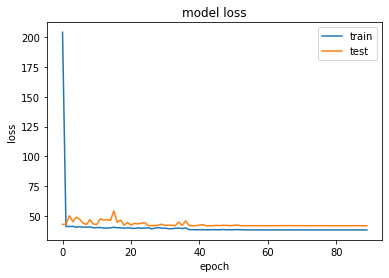

In [122]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [124]:
print(f'Expected {y_test[18]}')
predictions = model.predict(np.asarray(x_test[18]).reshape(-1,previous_draws*20))
predictions = [np.round(prediction) for prediction in predictions]
print(f'Predicted {predictions[0]}')

Expected [8, 16, 18, 22, 29, 31, 32, 33, 35, 36, 37, 38, 40, 43, 46, 51, 61, 70, 71, 76]
Predicted [ 4.  8. 12. 15. 19. 23. 27. 31. 35. 39. 42. 46. 50. 54. 58. 62. 66. 69.
 73. 77.]


In [ ]:
# Custom Train Loop

for epoch in range(epochs):
  print(f"\nEpoch {epoch+1} ==> ")
  for i in range(previous_draws,rows):

    # Get five previous draws
    inputs = []
    for j in range(previous_draws,0,-1):
      inputs += draws_df.loc[i-j]['Winning Numbers']
    inputs = np.asarray(inputs).reshape(-1,100)

    # Get target draw
    target = draws_df.loc[i]['Winning Numbers']

    # Make predictions
    with tf.GradientTape() as tape:
      predictions = model(inputs, training=True)
      loss_value = loss(target, predictions)

    # Update Gradients 
    gradients = tape.gradient(loss_value, model.trainable_weights)

    # Apply Gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

  if epoch%10 == 0:
    print(f'Loss {loss_value}')

# Section 4 - Predict next draws

In [ ]:
almost_five_minutes = 280
numbers = []


previous_draw_id , _ , _ , _ , _ , _ = get_active_draw()

# Fetch N previous draws
for i in range(previous_draws,0,-1):
  winning_numbers , _ , _ , _ , _ = get_draw(previous_draw_id-i)
  numbers += winning_numbers

predictions = model.predict(np.asarray(numbers).reshape(-1,previous_draws*20))
predictions = [np.round(prediction) for prediction in predictions]
print(f'P ==> {predictions[0]}')

total_correct_predictions = 0
draws = 0

while(True):
  current_draw_id , winning_numbers , month, day, hour, minute = get_active_draw()

  if(current_draw_id != previous_draw_id):
    previous_draw_id = current_draw_id;
    draws += 1

    # Remove first(oldest) 20 numbers
    numbers = numbers[20:]

    # Add latest draw numbers
    numbers += winning_numbers

    # Make prediction
    correct_predictions = 0;
    correct_numbers = []
    for prediction in predictions[0]:
      for number in winning_numbers:
        if(prediction==number):
          correct_predictions += 1
          correct_numbers.append(number)
    total_correct_predictions += correct_predictions


    predictions = model.predict(np.asarray(numbers).reshape(-1,previous_draws*20))
    predictions = [np.round(prediction) for prediction in predictions]
    print(f'D ===> {winning_numbers}')
    print(f'Correct predictions {correct_predictions} : {[correct_number for correct_number in correct_numbers]}')
    print(f'Average correct predictions {round((total_correct_predictions/(20*draws)*100),2)}%')
    print(f'\n\nP ==> {predictions[0]}')

    # Sleep for almost fime minutes
    time.sleep(almost_five_minutes)
  else:
    time.sleep(10)